In [3]:
import os
import pandas as pd
import json
import folium
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  
%load_ext autoreload
%autoreload 2

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO



# Question 1
## Part 1: A naive analysis

We load the data and compare the outcome for the two groups (participants and non-participants).

In [4]:
df_full = pd.read_csv('lalonde.csv')
df_full.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [5]:
df_treat_1 = df_full[df_full.treat == 1]
df_treat_0 = df_full[df_full.treat == 0]
df_treat_1.name = 'outcome_participants'
df_treat_0.name = 'outcome_nonparticipants'
print('Descriptive statistics for the outcome for participants:')
print(df_treat_1['re78'].describe())
print('\n\nDescriptive statistics for the outcome for non-participants:')
print(df_treat_0['re78'].describe())

Descriptive statistics for the outcome for participants:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


Descriptive statistics for the outcome for non-participants:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64


In [6]:
print('Descriptive statistics for all real earnings in 1974:')
print(df_full.re74.describe())
print('\n\nDescriptive statistics for all real earnings in 1975:')
print(df_full.re75.describe())

Descriptive statistics for all real earnings in 1974:
count      614.000000
mean      4557.546569
std       6477.964479
min          0.000000
25%          0.000000
50%       1042.330000
75%       7888.498250
max      35040.070000
Name: re74, dtype: float64


Descriptive statistics for all real earnings in 1975:
count      614.000000
mean      2184.938207
std       3295.679043
min          0.000000
25%          0.000000
50%        601.548400
75%       3248.987500
max      25142.240000
Name: re75, dtype: float64


Now we will plot the histograms of the outcome variable for the two groups (participants and non-participants) side by side (0 is untreated and 1 is treated):

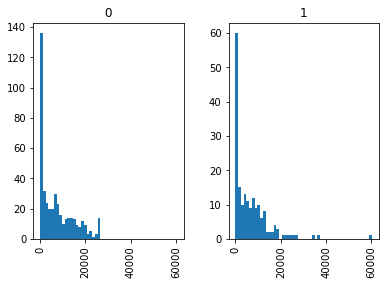

In [7]:
ax1, ax2 = df_full.hist(column='re78', by = 'treat', range=[0, df_full.re78.max()], bins = 50)


Number of participants with a higher 1978 earning than the maximum 1978 earning of non-participants:

In [8]:
df_treat_1[df_treat_1.re78 > df_treat_0.re78.max()].shape[0]

5

To the naive researcher [*tries hard to sound naive*] it seems that those who have not received the training actually have higher incomes because the mean is higher for the non-participants, and also, although the 25% quartile is higher for the participants, the 50% and 75% quartiles are considerably higher for the non-participants. Also, although the non-participants seem to have a much lower maximum, the number of participants who actually attain values higher than the maximum for the non-participants is only 5, which is a very small number of people. So basically, according to the naive researcher we're roleplaying as, the training program *backfired* and actually left the participants worse off than they would have been without the training.

## Part 2: Let's start acting like the ADA students we are

We will now compare the distributions of all variables across the treatment and control groups.

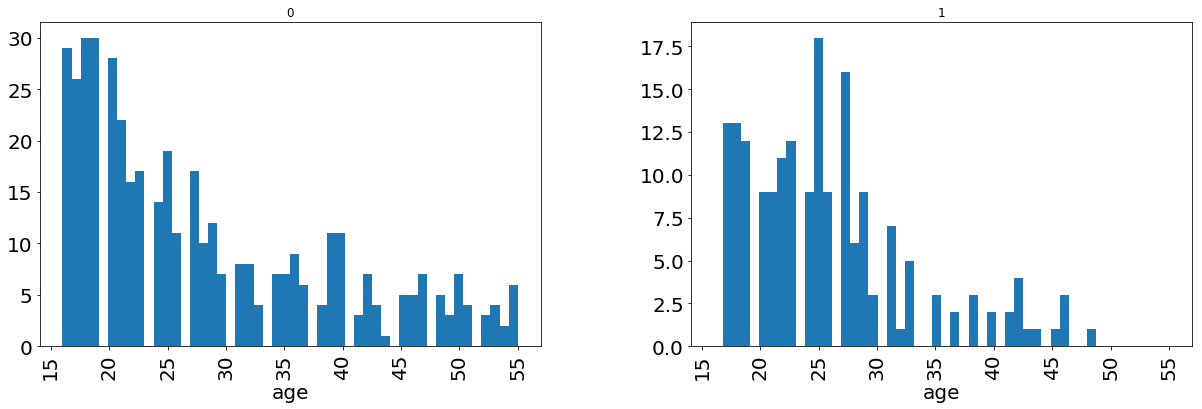

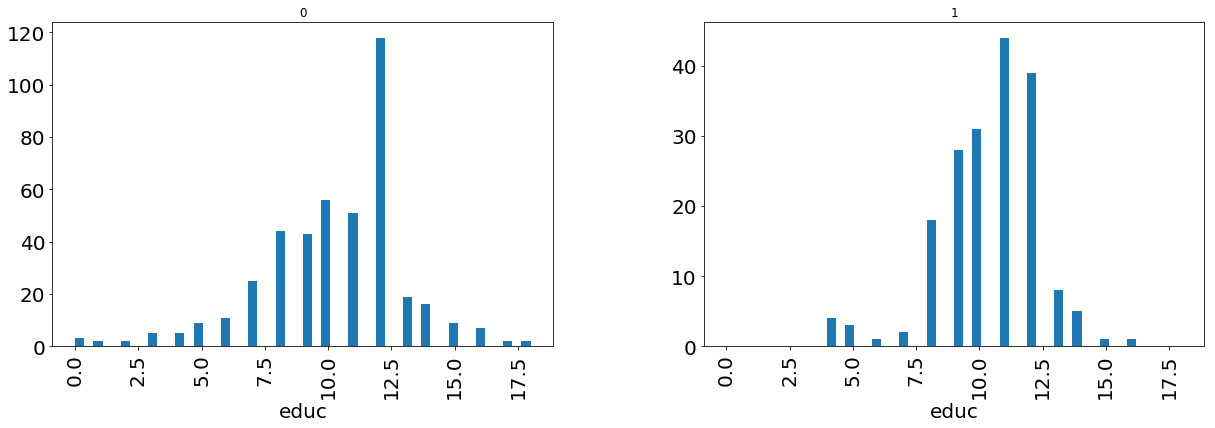

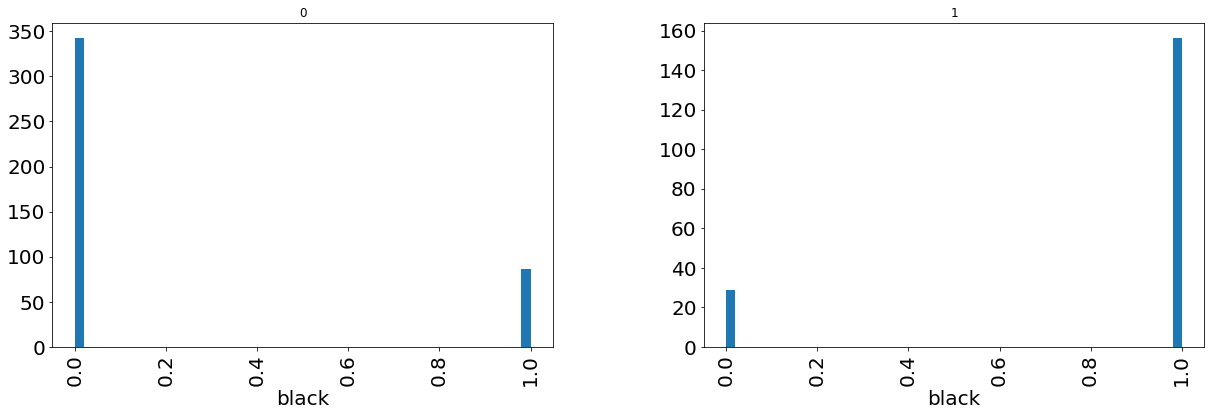

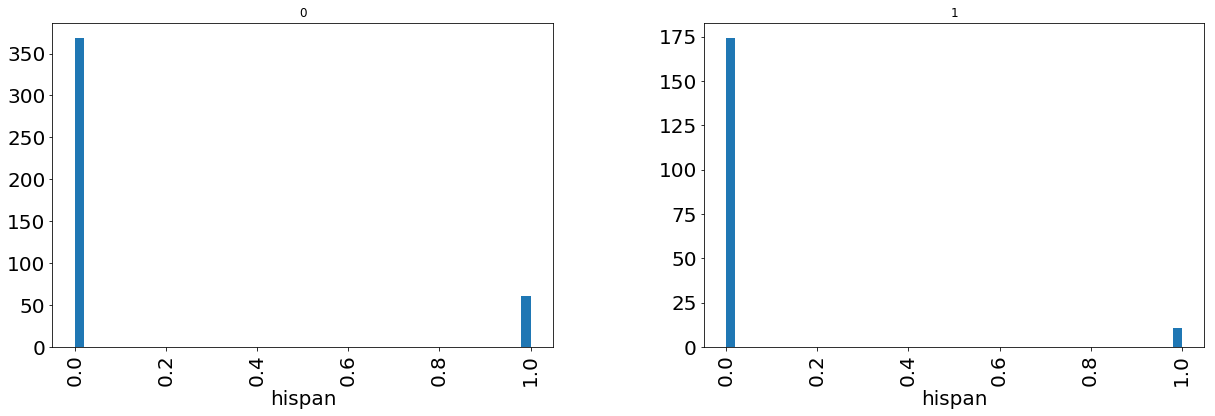

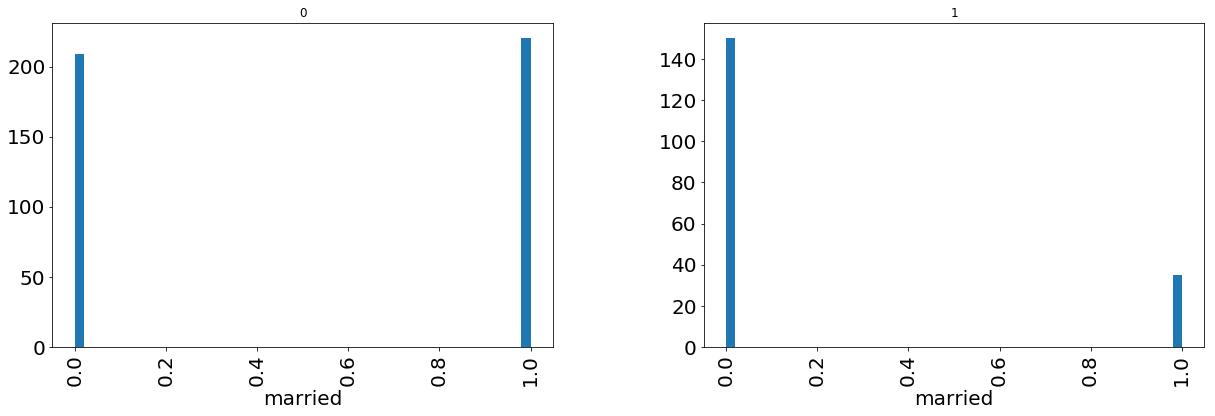

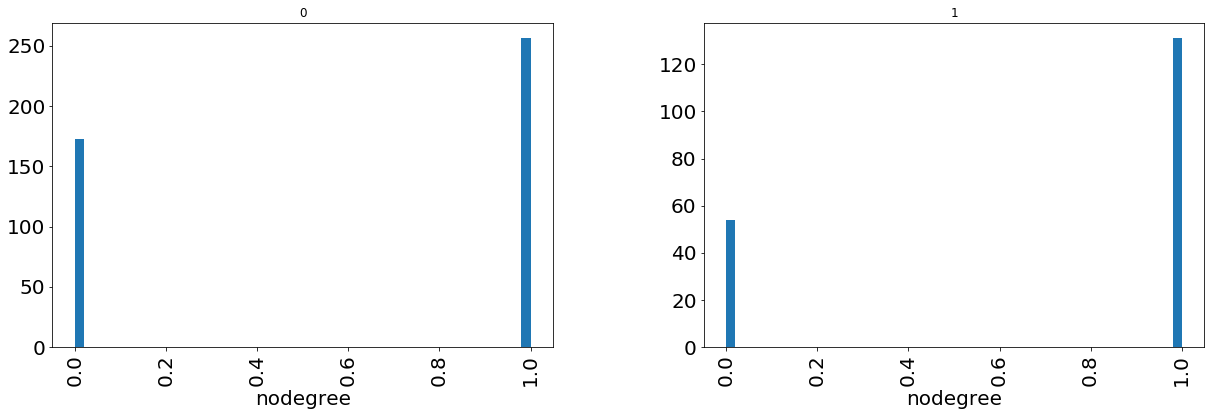

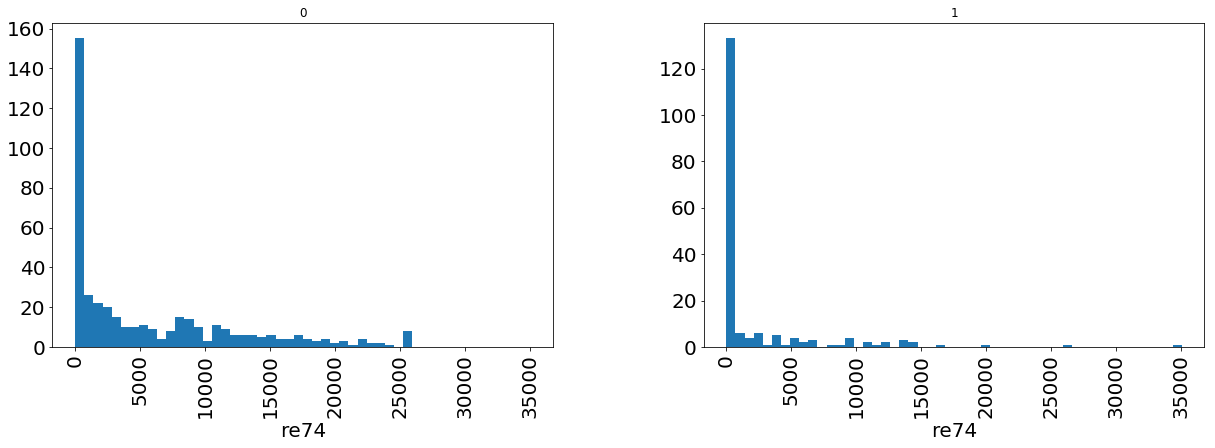

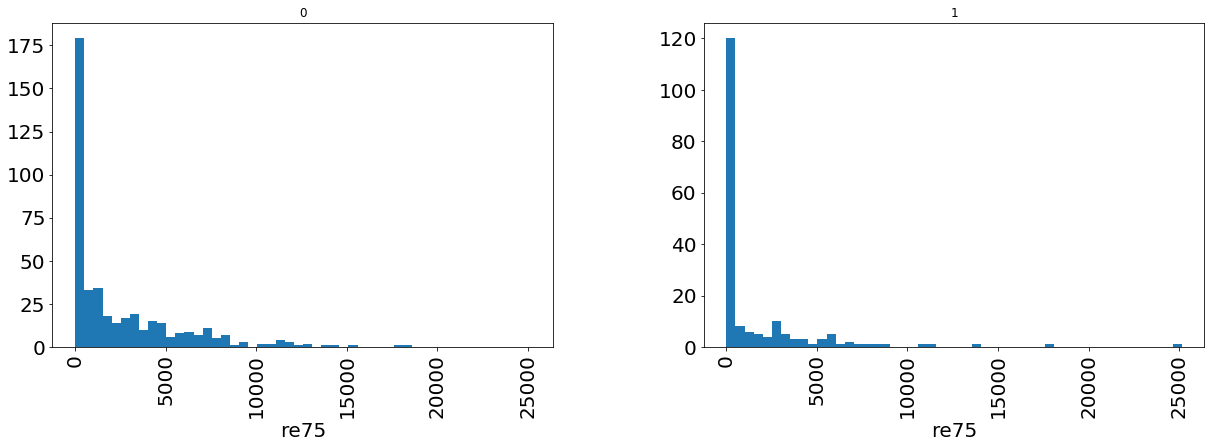

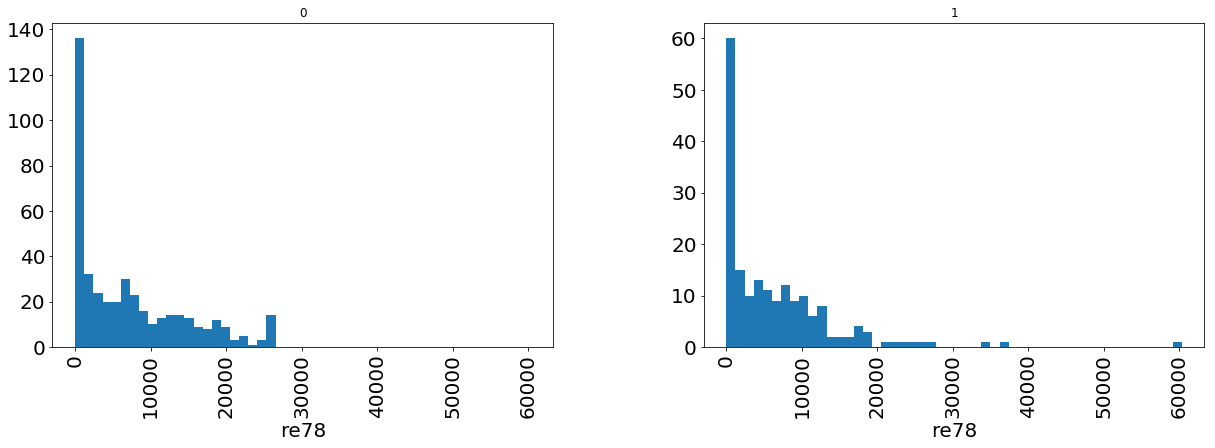

In [9]:
#plt.subplot(7,2,1)
#fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True)
def create_subplot(df, column_name):
    ax1, ax2 = df.hist(column=column_name, by='treat', range=[df[column_name].min(), df[column_name].max()], bins=50, figsize=(20,6), xlabelsize=20, ylabelsize=20)
    ax1.set_xlabel(column_name, size=20)
    ax2.set_xlabel(column_name, size=20)

for column_name in df_full.columns:
    if (column_name == 'id' or column_name == 'treat'):
        continue
    create_subplot(df_full, column_name)


The two groups seem unbalanced in three variables: black (0 for non-black, 1 for black), married (1 for married, 0 for not), and education. They are especially unbalanced in the black variable, where most of the control group are non-black and the majority of the treatment group are black. This means that existing differences in pay between different racial groups could be affecting our conclusions (not our conclusions though - the conclusions of the naive researcher in part 1). Let us see descriptive statistics for these 3 variables across the two groups in greater detail.

The first variable, black, is a Bernoulli random variable, so the mean is going to be meaningful (sorry for the pun). You can see the great difference between the two groups:

In [10]:
print('Treatment mean\n')
print(df_treat_1.black.mean())
print('\n\nControl mean\n')
print(df_treat_0.black.mean())

Treatment mean

0.8432432432432433


Control mean

0.20279720279720279


The second, married, is also a Bernoulli variable:

In [11]:
print('Treatment mean\n')
print(df_treat_1.married.mean())
print('\n\nControl mean\n')
print(df_treat_0.married.mean())

Treatment mean

0.1891891891891892


Control mean

0.5128205128205128


The third, education, looks relatively close to a Gaussian, albeit skewed (but bear in mind that it's discrete!).

In [12]:
print('Treatment\n')
print(df_treat_1.educ.describe())
print('\n\nControl\n')
print(df_treat_0.educ.describe())

Treatment

count    185.000000
mean      10.345946
std        2.010650
min        4.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       16.000000
Name: educ, dtype: float64


Control

count    429.000000
mean      10.235431
std        2.855238
min        0.000000
25%        9.000000
50%       11.000000
75%       12.000000
max       18.000000
Name: educ, dtype: float64


## Part 3: Propensity score calculation

We set the inverse of the regularisation parameter (C) to a very high value because we don't really need regularisation here; we just want to estimate the P(Z=1|x) for our data (for which a model like logistic regression is perfect because it predicts just that), which means we don't need to be able to generalise (so overfitting is not an issue). 
Afterwards, we'll be able to match 

In [27]:
from sklearn import linear_model
log_reg = linear_model.LogisticRegression(C=1e6)
features_df = df_full[['age', 'educ', 'black', 'hispan', 'married', 'nodegree']]
X = features_df.values.astype(float)
Y = df_full.treat.values
all_ids = df_full.id.values
log_reg.fit(X, Y)


LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [51]:
#The following function gives us two values per each sample, which are P(Z=0|x) and P(Z=1|x) respectively.
a = log_reg.predict_proba(X)
propensity_scores = a[:, 1]
propensity_scores[0:5]

array([ 0.58674564,  0.21430586,  0.64042713,  0.76455739,  0.68732504])

In preparation for the next part, we separate ids and propensity scores for the treatment and control groups.

In [30]:
treatment_prop_scores = propensity_scores[Y == 1]
treatment_ids = all_ids[Y == 1]
control_prop_scores = propensity_scores[Y == 0]
control_ids = all_ids[Y == 0]

## Part 4: Matching on propensity scores

Now we create a bipartite graph, with the treatment group member ids forming one part and the control group member ids forming the other. The weight we assign to the edge between a control case ($x_1$) and a treatment case ($x_2$) is equal to $ - | e( x_1 ) - e( x_2 ) |$. Therefore, running a maximum-weight, maximum-cardinality matching on this graph will yield a matching that matches every member of the treatment group (because they're fewer than the control group), each with exactly one member of the control group while no control case is matched with more than one treatment case, all while maximising the sum of negated absolute values - which is equivalent to minimising the sum of absolute values.

In [42]:
import networkx as nx
g = nx.Graph()
g.add_nodes_from(treatment_ids, bipartite=1)
g.add_nodes_from(control_ids, bipartite=0)
edge_list = []
for t_index in range(len(treatment_ids)):
    for c_index in range(len(control_ids)):
        edge_list.append((treatment_ids[t_index], control_ids[c_index], -abs(treatment_prop_scores[t_index] - control_prop_scores[c_index])))

g.add_weighted_edges_from(edge_list)
matching_result = nx.max_weight_matching(g, maxcardinality=True)

In the result returned, each edge appears twice (in both directions), so we're going to just keep those in the direction of treatment case to control case (all treatment case ids start with 'NSW').

In [53]:
matched = {k:matching_result[k] for k in matching_result if k[0]=='N'}

In [55]:
len(matched) == len(treatment_ids)

True

In [58]:
control_id_map = {v:k for k,v in enumerate(control_ids)}
treatment_id_map = {v:k for k,v in enumerate(treatment_ids)}

In [63]:
len(list(matching_result))

370

In [65]:
matched_df_1 = df_full[df_full.id.isin(matching_result)]

Now we do what we did in part 1, but this time only for the matched members of the control and treatment groups:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001906D3361D0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001906CFA6E10>], dtype=object)

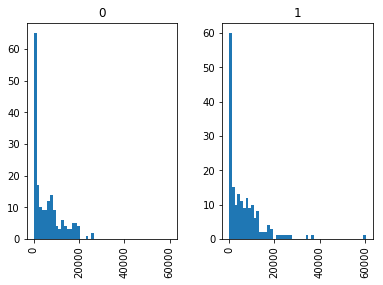

In [67]:
matched_df_1.hist(column='re78', by = 'treat', range=[0, matched_df_1.re78.max()], bins = 50)

In [70]:
print('Descriptive statistics for the matched cases in the treatment group\n')
print(matched_df_1[matched_df_1.treat==1].re78.describe())

print('\n\nDescriptive statistics for the matched cases in the control group')
print(matched_df_1[matched_df_1.treat==0].re78.describe())

Descriptive statistics for the matched cases in the treatment group

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


Descriptive statistics for the matched cases in the control group
count      185.000000
mean      5744.634084
std       6317.498541
min          0.000000
25%         54.675880
50%       3683.972000
75%       8923.991000
max      25564.670000
Name: re78, dtype: float64


The change is quite clear: now that we are matching the users based on their observed covariates, we can see that the training program has had a noticeable effect on the income of its participants, compared to people with roughly similar conditions who have not participated in the program. However, now we will also take a look at the histograms of other features in the data in this new, matched dataset, and we'll see that the analysis we just made was also rather naive.

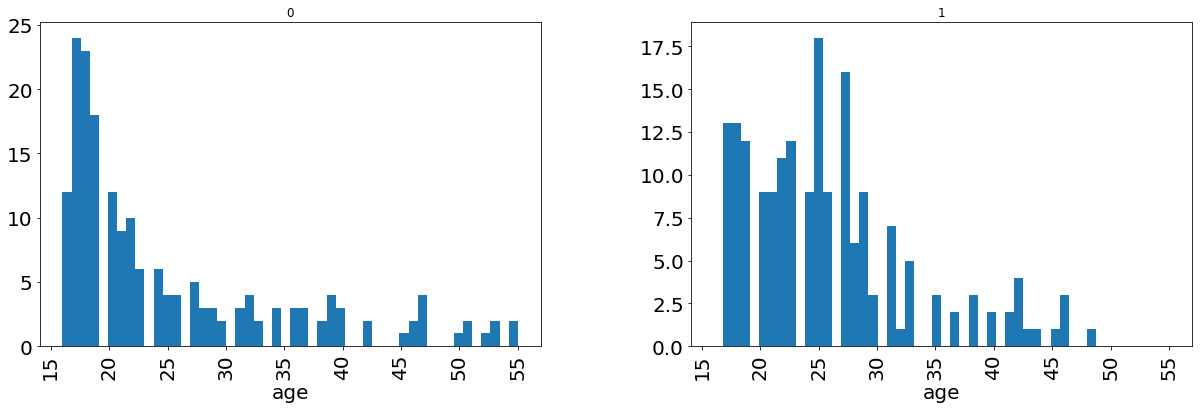

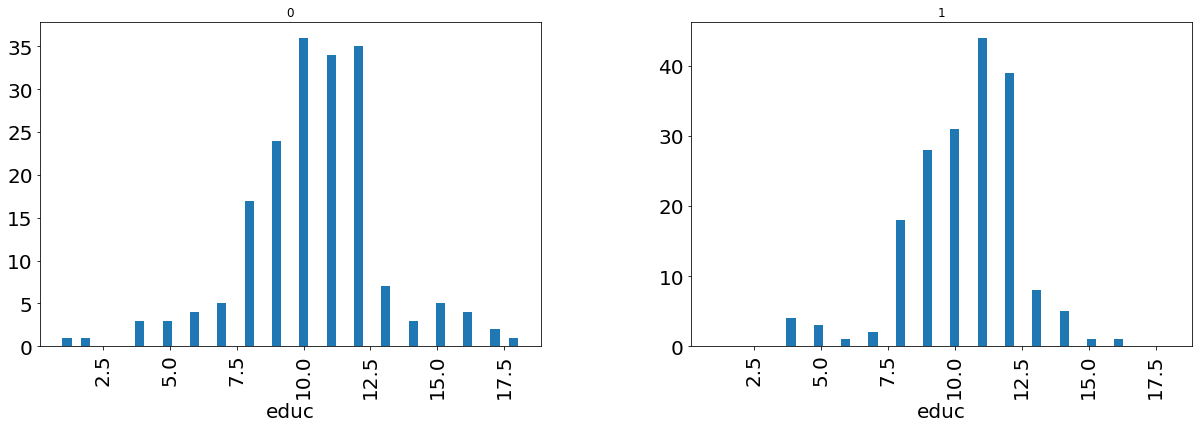

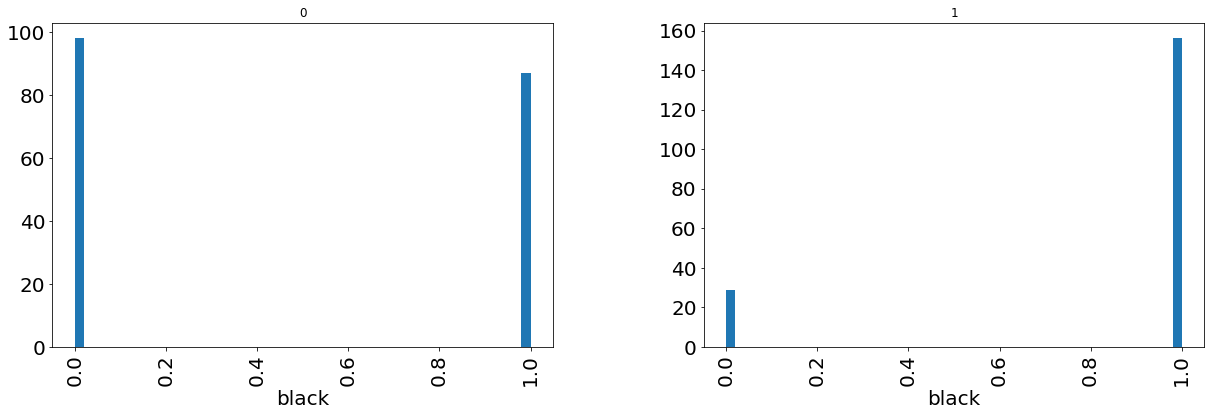

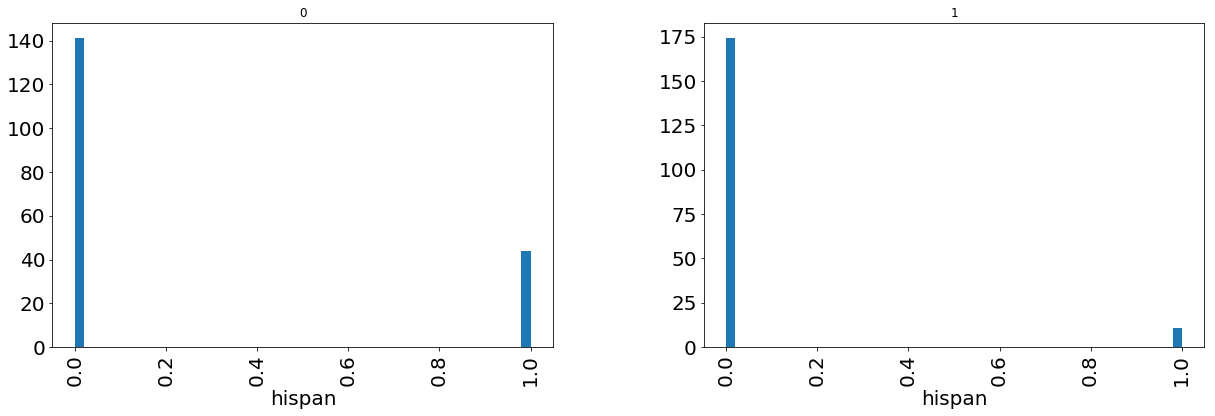

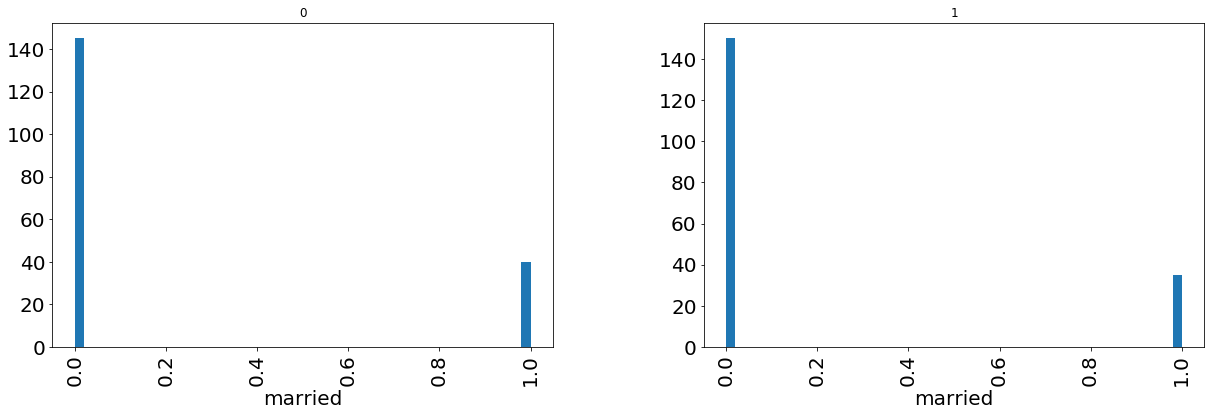

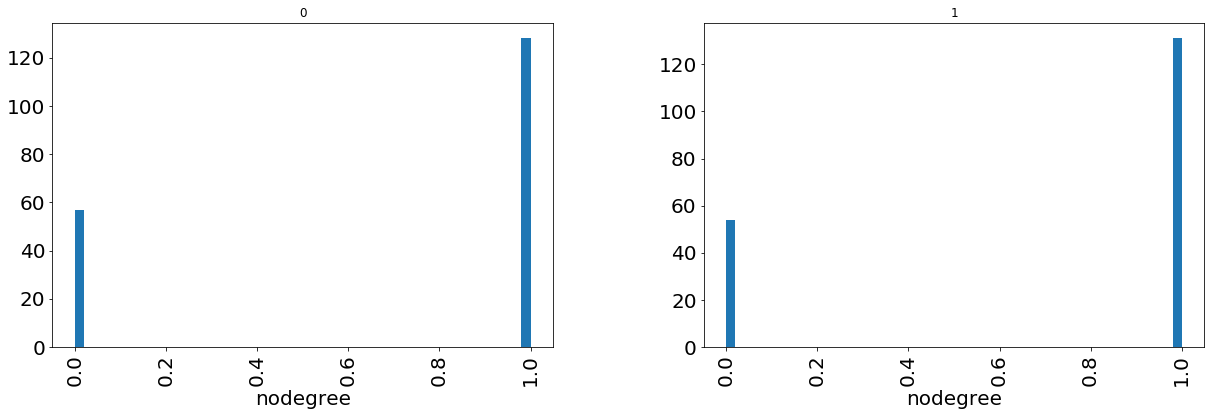

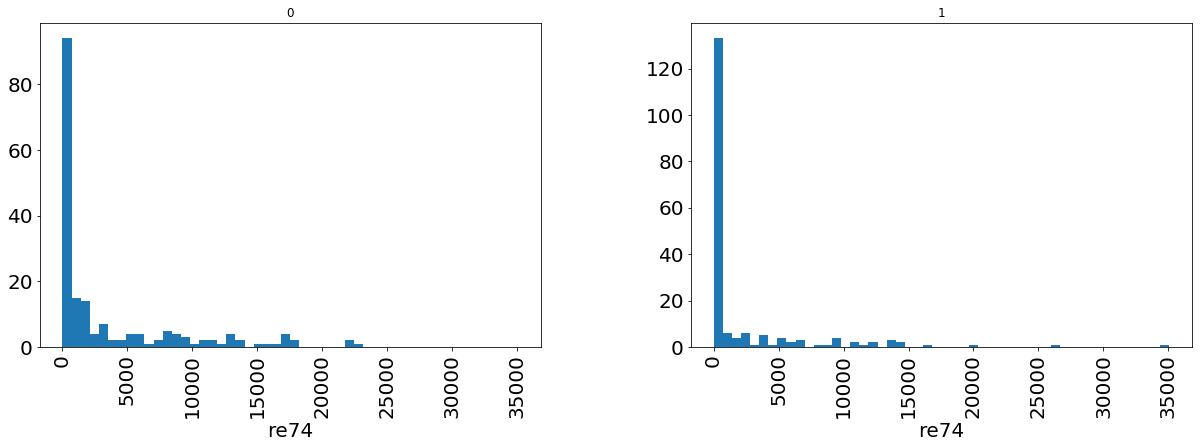

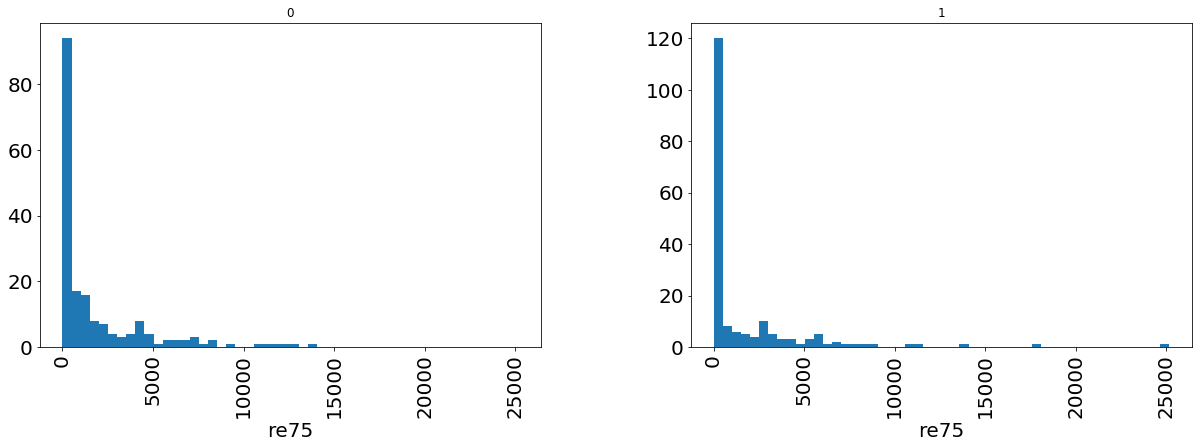

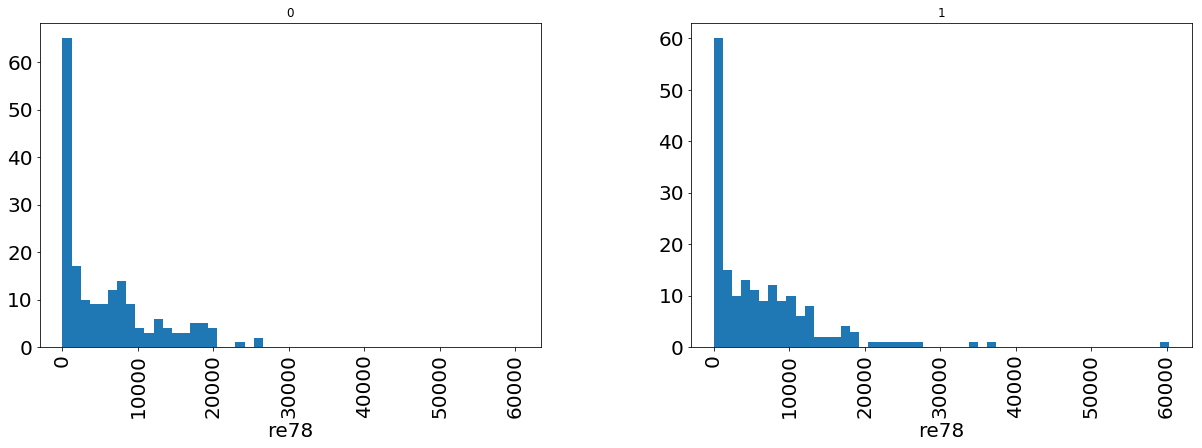

In [71]:
for column_name in matched_df_1.columns:
    if (column_name == 'id' or column_name == 'treat'):
        continue
    create_subplot(matched_df_1, column_name)

As you can see, now the married, educ and nodegree variables are much more balanced, but the extreme imbalance of the black variable still remains, and also the hispan variable has become rather unbalanced (although still not as much as the black variable). So, the two groups are still not sufficiently balanced and the conclusions we draw will probably be considerably affected by the imbalance in the black variable. Therefore, we should try to make sure that the matchings we create are also matched on this variable: a pair of a treatment case and a control case should only be a match if they have equal values for the black variable.

## Part 5: Also matching on the problematic variables